# Pre Processing Work - 152

Loading data

Remove nan , convert strings to numbers

Creating lable , Calculating mean from each 10 rows , Removeing lable

Creating Featurs

Saving data

---
---

# Creating Features matrix 

---

## Numpy arry - Feature Matrix

| Velocity(0)| Acceleration(1) | Stiffness(3) | Viscussness(4) | Energy Absorbed(5) |
|:----:|:-----:|:----:|:----:|:----:|
|0.0|0.0|0.0|0.0|0.0|


---

## Velocity calculation - Filter method

---
use a filters to calculate the velocity

$$
{\frac{sg}{s+g}}
\tag{2}
$$

by calculating

$$
Y_n = g[X_n - {\frac{Y_{n-1}}{s}}]
\tag{3}
$$

in the program

|Symbol|Discription|
|:------------:|:--------------:|
|$$s$$|Laplas operator|
|$$g$$|Filter constent|
|$$X_n$$|$$n^{th}$$ operetion positon input|
|$$Y_n$$|$$n^{th}$$ operation velocity output|

---

## Acceleration calculation - Method 01(moving average filter)

---

$$
A_n ={\frac {V_{n+w} - V_{n}}{t_{n+w} - t_n}}
\tag{4}
$$

---

## Striffness veriation

---

In order to identify stiffness veriation profile

$$
{Stiffness  = \frac{Force Responce }{Defomation Distance}}
$$

$$
{Stiffness  = \frac{F_{res} }{x}}
$$

---

## Viscussness variation

---

In order to identify stiffness veriation profile

$$
{Viscussness  = \frac{Force Responce }{Velocity}}
$$

$$
{Viscussness = \frac{F_{res}}{\dot{x}} }
$$


---

# 2.6 Energy absorbed from the object

---

$$
{dx = (Encoder_{count_1} - Encoder_{count_0}) \times 0.005}
$$ 


$$
f = \frac{Force_1 + Force_0 }{2}
$$


$$
%{Energy_{sum} = \sum_{x = x_0}^{x_1}  f dx}
dA = f \times dx
$$


$$
Energy_{sum} = Energy_{sum} + dA
$$


dx > 0 when
$$
cos[tan^{-1}[ \frac{df}{dx} ]]  > 0
$$

dx < 0 when
$$
cos[tan^{-1}[ \frac{df}{dx} ]]  < 0
$$






## Ceating f eature metrix 

| Time(0) | Force command(1)| RTOB force feedback(2) | Counts(3)|  Velocity(4)| Acceleration(5) | Defomation(6) | Stiffness(7) |
|:-----:|:----:|:----:|:----:|:-----:|:----:|:----:|:----:|
|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|


In [12]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt


In [13]:
## Step by step process in pre process 
# 1. Load data file to pandas data frame
def load_data(file_parth):
    df = pd.read_csv(file_parth, sep=",", names=["Time", "Force_command", "Force_responce", "Position_responce"])
    #print(df.shape)

    df = df.dropna() # 2. drop NaN
    #print(df.shape)
    #df

    # 2. Changing data type of position column to string to float
    data_type = df["Position_responce"].dtype
    print(data_type)

    if data_type != "int64":
        #print("needed to change dtype")
        df['Position_responce'] = pd.to_numeric(df['Position_responce'],errors='coerce')
        df["Position_responce"].dtype
    else:
        print("No need to change the data type")
    
    data_type = df["Position_responce"].dtype
    #print(data_type)

    return df

## Mean calculation from 0 to 99 

In [14]:
# Get the mean of each 100 value

def mean_calculator(df):
    # Creating lable column with same lable value for each 10 ~ 20 rows
    df['label']=np.divmod(np.arange(len(df)),1500)[0]+1

    # Mean calcuating under same lable value
    mean_with_lable = (df.groupby((df.label != df.label.shift()).cumsum()).mean().reset_index(drop=True))

    # Remove the lable from the dataframe
    df_no_fetures = mean_with_lable.drop(['label'], axis=1)
    
    # print the datafroame with no lales
    return df_no_fetures

In [15]:
def feature_creator(df_no_fetures):
    # Trnsform df to np array
    #print(df_no_fetures.shape)
    measurements_arr = df_no_fetures.to_numpy()
    
    rows_of_matrix = df_no_fetures.shape[0]    # Dimention of the matrix
        
    # Creating feature array
    features = np.zeros((rows_of_matrix,9))
    
    # Input Time, Force input, Force responce, Time to the features
    features[:,0] = measurements_arr[:,0]
    features[:,1] = measurements_arr[:,1]
    features[:,2] = measurements_arr[:,2]
    features[:,3] = measurements_arr[:,3]*0.005
    
    
    
    # Calulating features - Velocity
    # add velocity to 4 column on the features matrix
    g = 3
    x = 0
    velocity_sum = 0
    for x in range (rows_of_matrix - 1):
      time_deff = features[(x+1),0] - features[x,0]
      velocity_sum = velocity_sum + features[x,0]*time_deff      
      features[(x+1),4] = g*(features[(x+1),3] - velocity_sum)
    
    # Calulating features - Acceleration
    # add Accleration to 1 column on the features matrix
    window_with = 3000
    x = 0
    for x in range (rows_of_matrix - window_with):
      velocity_diff = features[(x+window_with),4] - features[x,4]                  # from velocity colomn 4 - Filter based velocity
      time_deff = features[(x+window_with),0] - features[x,0]                      # from time colomn
      features[(x+window_with),5] = velocity_diff / time_deff                      # save to featurer[:,5]
    
    # Calculating features - Stiffness variation
    # add stiffness to 6 column
    x = 0
    for x in range (2000,rows_of_matrix,1):
        if( features[x,3] != 0 ):
            features[x,6] = (features[x,2] / features[x,3])                       # calculate stiffness and add it to 
            
    # Calculating features - Viscussness
    # add viscussness to 7 column
    x = 0
    for x in range (rows_of_matrix):
        if( features[x,5] > 0.002 or features[x,5] < -0.002):                       # acceration shoud be less that 0.002
            features[x,7] = features[x,2] / (features[x,4] )
    
    # Calculating feature - Energy Absorbed
    # add energy total to 8 column
    x=0
    cumulative_energy_sum = 0
    for x in range (rows_of_matrix - 1):
        cumulative_energy_sum = cumulative_energy_sum + ( (features[x,2] + features[x+1,2]) / 2 ) * (features[x+1,3] - features[x,3])
        features[x+1,8] = cumulative_energy_sum
    
    return features.T

In [16]:
# Defining function to create .ts file
# give numpy 2d array to the function
# numpy array should be 
# [time,     time,     time,   ..., time    ]
# [feature1, feature1, feature1,...,feature1]
# [feature2, feature2, feature2,...,feature2]
# [feature3, feature3, feature3,...,feature3]

def save_to_ts(np_array):
    import sys
    import numpy as np
    lenth_of_row = np_array.shape[1]
    print(lenth_of_row)
    original_stdout = sys.stdout # Save a reference to the original standard output

    with open('haptic_data_2.ts', 'a+') as file_point:
        sys.stdout = file_point # Change the standard output to the file we created.
        for arr in np_array:
            count=0
            for element in arr:
                print(element,end="")
                count=count+1
                if count ==lenth_of_row:
                    print(":",end="")
                else:
                    print(",",end="")

        print("Orange")
    
    sys.stdout = original_stdout # Reset the standard output to its original value


In [18]:
# import files from list

file_list = ["./1_1_1_1.txt","./1_1_1_2.txt","./1_1_1_3.txt","./1_1_1_4.txt","./1_1_2_1.txt","./1_1_2_2.txt","./1_1_2_3.txt","./1_1_2_4.txt","./1_1_3_1.txt","./1_1_3_2.txt","./1_1_3_3.txt","./1_1_3_4.txt","./1_1_4_1.txt","./1_1_4_2.txt","./1_1_4_3.txt","./1_1_4_4.txt"]

In [19]:
# for loop for all 

for file_parth in file_list:
    data_frame=load_data(file_parth)
    mean_df = mean_calculator(data_frame)
    all_T = feature_creator(mean_df)
    save_to_ts(all_T)

/home/malitjkd/anaconda3/envs/ai37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


object
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734
int64
No need to change the data type
1734


In [5]:


#df11.plot(x="Time",y=["Position_responce"])
#plt.plot(df["Time"], df["Position_responce"]*0.005, label = "11", color='black')
#plt.plot(df["Time"], df["Force_responce"], label = "11", color='green')
#plt.plot(df["Time"], df["Force_command"], label = "11", color='blue')


#plt.xlabel('Time(s)',fontsize=14)
#plt.ylabel('Position Variation(mm)',fontsize=14)

#plt.legend(fontsize=14,bbox_to_anchor=(0.35, 0.71))

#plt.show()

In [6]:

#plt.plot(df["Position_responce"]*0.005, df["Force_responce"], label = "Orange_1_1", color='red')

#plt.xlabel('Position variation(mm)',fontsize=14)
#plt.ylabel('Force responce(N)',fontsize=14)

#plt.legend(fontsize=14,bbox_to_anchor=(0.45, 1.0))

#plt.show()

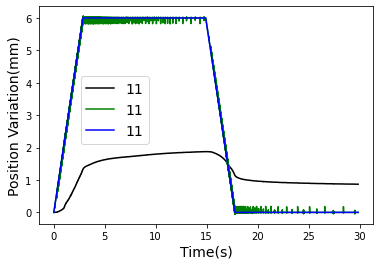

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#df11.plot(x="Time",y=["Position_responce"])
plt.plot(df_no_fetures["Time"], df_no_fetures["Position_responce"]*0.005, label = "11", color='black')
plt.plot(df_no_fetures["Time"], df_no_fetures["Force_responce"], label = "11", color='green')
plt.plot(df_no_fetures["Time"], df_no_fetures["Force_command"], label = "11", color='blue')


plt.xlabel('Time(s)',fontsize=14)
plt.ylabel('Position Variation(mm)',fontsize=14)

plt.legend(fontsize=14,bbox_to_anchor=(0.35, 0.71))

plt.show()

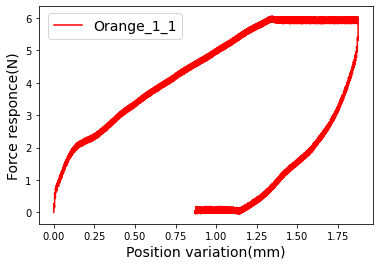

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.plot(df_no_fetures["Position_responce"]*0.005, df_no_fetures["Force_responce"], label = "Orange_1_1", color='red')

plt.xlabel('Position variation(mm)',fontsize=14)
plt.ylabel('Force responce(N)',fontsize=14)

plt.legend(fontsize=14,bbox_to_anchor=(0.45, 1.0))

plt.show()

# 2.2

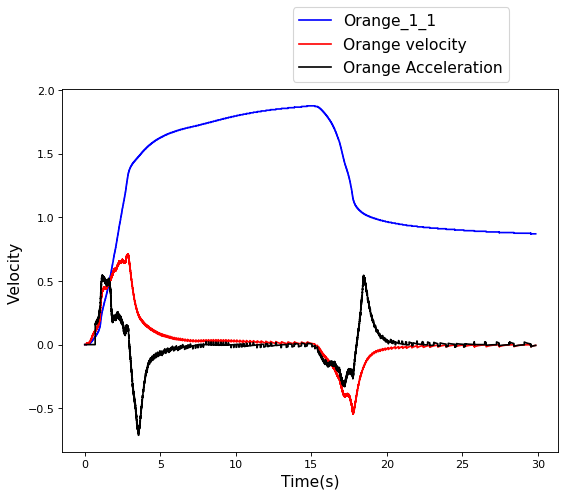

In [14]:
plt.figure(figsize=(8, 6), dpi=80)

# position variation and velocity varation to the time
plt.plot(df_no_fetures["Time"], df_no_fetures["Position_responce"]*0.005, label = "Orange_1_1", color='blue')

# time vs velocity
plt.plot(df_features[:,0],features[:,0], label = "Orange velocity", color='red')

# Time vs Acceleration
plt.plot(df_features[:,0],features[:,1], label = "Orange Acceleration", color='black')


plt.xlabel('Time(s)',fontsize=14)
plt.ylabel('Velocity ',fontsize=14)

plt.legend(fontsize=14,bbox_to_anchor=(0.45, 1.0))

plt.show()

# 2.3 Striffness veriation

---

In order to identify stiffness veriation profile

$$
{Stiffness  = \frac{Force Responce }{Defomation Distance}}
$$

$$
{Stiffness  = \frac{F_{res} }{x}}
$$


In [15]:
for x in range (2000,df_features.shape[0],1):
    if( df_features[x,3] != 0 ):
        features[x,2] = df_features[x,2] / ( df_features[x,3] * 0.005 );    # calculate deformation

print(features)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 ...
 [-5.89260598e-03 -6.16657677e-03 -1.14942529e-06  0.00000000e+00
   0.00000000e+00]
 [-5.88854715e-03 -6.16231471e-03 -1.14942529e-06  0.00000000e+00
   0.00000000e+00]
 [-5.88448847e-03 -6.15805362e-03 -1.14942529e-06  0.00000000e+00
   0.00000000e+00]]


# 2.4 Viscussness variation

---

In order to identify stiffness veriation profile

$$
{Viscussness  = \frac{Force Responce }{Velocity}}
$$

$$
{Viscussness = \frac{F_{res}}{\dot{x}} }
$$

In [16]:
#for x in range (9000,df_features.shape[0],1):
#    if( features[x,0] > 0.02 and features[x,0] < -0.02):           # acceleration should not be zero
#        features[x,3] = df_features[x,2] / (features[x,0] );       # calculate deformation
        
for x in range (0,df_features.shape[0],1):
    if( features[x,0] > 0.002 or features[x,0] < -0.002):
        features[x,3] = df_features[x,2] / (features[x,0] );
    

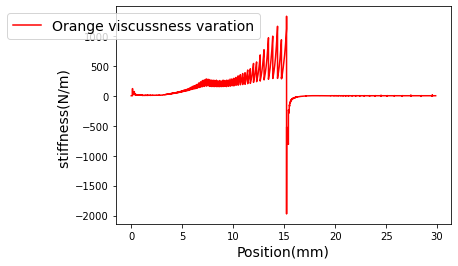

In [17]:
# Position vs Stiffness varation
#plt.plot(df_features[:,3]*0.005,features[:,2], label = "Orange Acceleration", color='black')

# Position vs Stiffness varation
#plt.plot(df_features[:,3]*0.005,features[:,3], label = "Orange viscussness varation", color='red')
plt.plot(df_features[:,0],features[:,3], label = "Orange viscussness varation", color='red')


plt.xlabel('Position(mm)',fontsize=14)
plt.ylabel('stiffness(N/m) ',fontsize=14)

plt.legend(fontsize=14,bbox_to_anchor=(0.45, 1.0))

plt.show()

# 2.6 Energy absorbed from the object

---

$$
{dx = (Encoder_{count_1} - Encoder_{count_0}) \times 0.005}
$$ 


$$
f = \frac{Force_1 + Force_0 }{2}
$$


$$
%{Energy_{sum} = \sum_{x = x_0}^{x_1}  f dx}
dA = f \times dx
$$


$$
Energy_{sum} = Energy_{sum} + dA
$$


dx > 0 when
$$
cos[tan^{-1}[ \frac{df}{dx} ]]  > 0
$$

dx < 0 when
$$
cos[tan^{-1}[ \frac{df}{dx} ]]  < 0
$$


In [18]:
cumulative_energy_sum = 0

for x in range (1,df_features.shape[0]-1,1):
  cumulative_energy_sum = cumulative_energy_sum + ( (df_features[x,2] + df_features[x+1,2]) / 2 ) * (df_features[x+1,3] - df_features[x,3])*0.005
  features[x+1,4] = cumulative_energy_sum

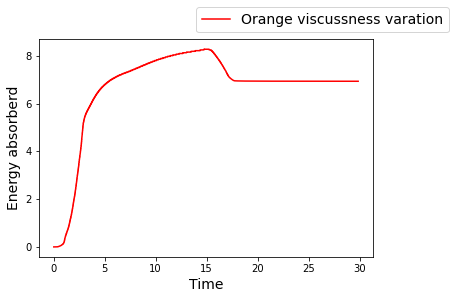

In [19]:
# Position vs Stiffness varation
plt.plot(df_features[:,0],features[:,4], label = "Orange viscussness varation", color='red')

plt.xlabel('Time',fontsize=14)
plt.ylabel('Energy absorberd',fontsize=14)

plt.legend(fontsize=14,bbox_to_anchor=(0.45, 1.0))

plt.show()

---


# Plotting the features and fine tune them

In [20]:
features

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.89260598e-03, -6.16657677e-03, -1.14942529e-06,
         1.69704203e-04,  6.94026509e+00],
       [-5.88854715e-03, -6.16231471e-03, -1.14942529e-06,
         1.69821176e-04,  6.94026509e+00],
       [-5.88448847e-03, -6.15805362e-03, -1.14942529e-06,
         1.69938306e-04,  6.94026509e+00]])

# Collecting data to one matrix 

In [21]:
#all = np.concatenate((df_features,features), axis=1)

all = np.zeros((df_no_fetures.shape[0],9))
print(all.shape)


(130000, 9)


# Nomalization

$$
\frac{ Valiure - min value}{ max value - min value}
$$

In [22]:
all[:,0] = ( df_features[:,0] - min(df_features[:,0]) )/( max(df_features[:,0]) - min(df_features[:,0]) )    # Time
all[:,1] = ( df_features[:,1] - min(df_features[:,1]) )/( max(df_features[:,1]) - min(df_features[:,1]) )    # Force command
all[:,2] = ( df_features[:,2] - min(df_features[:,2]) )/( max(df_features[:,2]) - min(df_features[:,2]) )    # Force responce
all[:,3] = ( df_features[:,3] - min(df_features[:,3]) )/( max(df_features[:,3]) - min(df_features[:,3]) )    # Position 

all[:,4] = ( features[:,0] - min(features[:,0]) )/(max(features[:,0]) - min(features[:,0]))                  # Velocity
all[:,5] = ( features[:,1] - min(features[:,1]) )/(max(features[:,1]) - min(features[:,1]))                  # Acceration
all[:,6] = ( features[:,2] - min(features[:,2]) )/(max(features[:,2]) - min(features[:,2]))                  # stiffness
all[:,7] = ( features[:,3] - min(features[:,3]) )/(max(features[:,3]) - min(features[:,3]))                  # viscocity
all[:,8] = ( features[:,4] - min(features[:,4]) )/(max(features[:,4]) - min(features[:,4]))                  # energy absorbed


# Saving data frame as ".CSV" file

In [23]:
np.savetxt("df1111.csv", all, delimiter=",")

end

---

# 2.5 Visible mass variation

---

In order to identify stiffness veriation profile

$$
{Visible mass  = \frac{Force Responce }{Acceleration}}
$$

$$
{Visible mass = \frac{F_{res}}{\ddot{x}}}
$$

In [24]:
#for x in range (1,df_features.shape[0],1):
#    if( features[x,1] > 0.005 or features[x,1] < -0.005 ):
#        features[x,4] = df_features[x,2] / ( features[x,1] );    # calculate deformation


In [25]:
# Position vs Stiffness varation
# plt.plot(df_features[:,3]*0.005,features[:,4], label = "Orange visible mass varaition", color='red')
# plt.plot(df_features[:,0],features[:,4], label = "Orange viscussness varation", color='red')


#plt.xlabel('accelaration',fontsize=14)
#plt.ylabel('Visible Mass ',fontsize=14)

#plt.legend(fontsize=14,bbox_to_anchor=(0.45, 1.0))

#plt.show()